In [290]:
import polars as pl
from influxdb_client.client.influxdb_client import InfluxDBClient
from influxdb_client import __version__ as influxdb_version
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# InfluxDB connection
url = "http://192.168.1.17:8086"
token = "_gCwoPkdKM6aF-SXB9crHatd4lKFBXKVcBHhyHMgCqTI2GvsxWkO6qooThciZp49Ra-dQR9B6jOd_ve5isMcHw=="
org = "mush"
bucket = "bucket"

client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()

In [3]:
# Look at the exact structure of one record
detail_query = '''
from(bucket: "bucket")
  |> range(start: -10m)
  |> filter(fn: (r) => r["topic"] =~ /temperature$/)
  |> limit(n: 1)
'''

result = query_api.query(detail_query)

print("Detailed record structure:")
for table in result:
    for record in table.records:
        print("\nTimestamp:", record.get_time())
        print("Value:", record.get_value())
        print("\nAll fields and tags:")
        for key, value in record.values.items():
            print(f"  {key}: {value}")

Detailed record structure:

Timestamp: 2025-02-26 20:14:59.995459+00:00
Value: 77.07

All fields and tags:
  result: _result
  table: 0
  _start: 2025-02-26 20:14:53.765556+00:00
  _stop: 2025-02-26 20:24:53.765556+00:00
  _time: 2025-02-26 20:14:59.995459+00:00
  _value: 77.07
  _field: value
  _measurement: mqtt_consumer
  controller: C1
  device: bme280_0
  host: tele_0
  measurement: temperature
  topic: mush/controllers/C1/sensors/bme280_0/temperature
  type: sensors

Timestamp: 2025-02-26 20:15:00.006523+00:00
Value: 77.34

All fields and tags:
  result: _result
  table: 1
  _start: 2025-02-26 20:14:53.765556+00:00
  _stop: 2025-02-26 20:24:53.765556+00:00
  _time: 2025-02-26 20:15:00.006523+00:00
  _value: 77.34
  _field: value
  _measurement: mqtt_consumer
  controller: C1
  device: bme280_1
  host: tele_0
  measurement: temperature
  topic: mush/controllers/C1/sensors/bme280_1/temperature
  type: sensors

Timestamp: 2025-02-26 20:15:00.094626+00:00
Value: 75.92

All fields and

In [291]:
# Find all temperature and humidity measurements
structure_query = '''
from(bucket: "bucket")
  |> range(start: -18h)
  |> filter(fn: (r) => r["topic"] =~ /(temperature|humidity)$/)
  |> distinct(column: "topic")
'''

result = query_api.query(structure_query)

print("Sensors found:")
for table in result:
    for record in table.records:
        print(f"  - {record.get_value()}")

# Then get the actual data
query = '''
from(bucket: "bucket")
  |> range(start: -36h)
  |> filter(fn: (r) => r["topic"] =~ /(temperature|humidity)$/)
'''

result = query_api.query(query)

# Collect data
data = {
    "timestamp": [],
    "value": [],
    "topic": []
}

for table in result:
    for record in table.records:
        data["timestamp"].append(record.values['_time'])
        data["value"].append(record.values['_value'])
        data["topic"].append(record.values['topic'])

# Create DataFrame and split out sensor and measurement type
df = pl.DataFrame(data)
df = df.with_columns([
    pl.col('topic').str.split('/').list.get(-2).alias("sensor"),
    pl.col('topic').str.split('/').list.get(-1).alias("measurement")
])

# Now we can pivot this to get both temperature and humidity readings

Sensors found:
  - mush/controllers/C1/sensors/bme280_0/humidity
  - mush/controllers/C1/sensors/bme280_0/temperature
  - mush/controllers/C1/sensors/bme280_1/humidity
  - mush/controllers/C1/sensors/bme280_1/temperature
  - mush/controllers/C1/sensors/dht_0/humidity
  - mush/controllers/C1/sensors/dht_0/temperature
  - mush/controllers/C1/sensors/ds18b20_0/temperature
  - mush/controllers/C1/sensors/ds18b20_1/temperature
  - mush/controllers/C1/sensors/sht_0/humidity
  - mush/controllers/C1/sensors/sht_0/temperature
  - mush/controllers/C3/sensors/scd_0/humidity
  - mush/controllers/C3/sensors/scd_0/temperature


In [298]:
# First collect the data in lists (vectorized form)
data = {
    "timestamp": [],
    "value": [],
    "topic": []
}
"""Gets """
for table in result:
    for record in table.records:
        # Access directly from the values dictionary
        data["timestamp"].append(record.values['_time'])
        data["value"].append(record.values['_value'])
        data["topic"].append(record.values['topic'])


# Create Polars DataFrame
df = pl.DataFrame(data)
df = df.with_columns(
    pl.col('topic').str.split('/').list.get(-2).alias("sensor")
)

In [299]:
min_time:datetime = df["timestamp"].min()
min_time=min_time.replace(second = 0, microsecond = 0)
max_time:datetime = df["timestamp"].max()
max_time=max_time.replace(second=0, microsecond=0)

grid = pl.datetime_range(
    start=min_time,
    end=max_time,
    interval="15s",
    eager=True
).alias("timestamp")


In [300]:
# Create grid DataFrame
grid_df = pl.DataFrame({"timestamp": grid, "value": None})

# Process all sensors at once using groupby
df_resampled = (df
    .group_by("sensor")
    .map_groups(lambda group: (
        pl.concat([
            group.select(["timestamp", "value", "sensor"]),
            grid_df.with_columns(pl.lit(group["sensor"][0]).alias("sensor"))
        ])
        .sort("timestamp")
        .with_columns(pl.col("value").interpolate())
    ))
    # Now pivot with the CORRECT syntax
    .pivot(
        on="sensor",
        index="timestamp",
        values="value",
        aggregate_function="first"
    )
)

print("Resampled data:")
print(df_resampled.head())

Resampled data:
shape: (5, 8)
┌────────────────────────────┬──────────┬───────┬───────────┬───────┬───────────┬──────────┬───────┐
│ timestamp                  ┆ bme280_0 ┆ dht_0 ┆ ds18b20_1 ┆ sht_0 ┆ ds18b20_0 ┆ bme280_1 ┆ scd_0 │
│ ---                        ┆ ---      ┆ ---   ┆ ---       ┆ ---   ┆ ---       ┆ ---      ┆ ---   │
│ datetime[μs, UTC]          ┆ f64      ┆ f64   ┆ f64       ┆ f64   ┆ f64       ┆ f64      ┆ f64   │
╞════════════════════════════╪══════════╪═══════╪═══════════╪═══════╪═══════════╪══════════╪═══════╡
│ 2025-02-26 15:00:00 UTC    ┆ null     ┆ null  ┆ null      ┆ null  ┆ null      ┆ null     ┆ null  │
│ 2025-02-26 15:00:09.486459 ┆ 74.41    ┆ null  ┆ null      ┆ null  ┆ null      ┆ null     ┆ null  │
│ UTC                        ┆          ┆       ┆           ┆       ┆           ┆          ┆       │
│ 2025-02-26 15:00:09.487209 ┆ 58.36    ┆ null  ┆ null      ┆ null  ┆ null      ┆ null     ┆ null  │
│ UTC                        ┆          ┆       ┆           ┆

In [301]:
# Create grid DataFrame (same as before)
grid_df = pl.DataFrame({"timestamp": grid, "value": None})

# Process all sensors/measurements
df_resampled = (df
    .group_by("topic")
    .map_groups(lambda group: (
        pl.concat([
            group.select(["timestamp", "value", "topic"]),
            grid_df.with_columns(pl.lit(group["topic"][0]).alias("topic"))
        ])
        .sort("timestamp")
        .with_columns(pl.col("value").interpolate())
    ))
    .pivot(
        on="topic",
        index="timestamp",
        values="value",
        aggregate_function="first"
    )
    # Rename columns to something sensible
    .rename({
        "mush/controllers/C1/sensors/ds18b20_0/temperature": "ds18b20_0",
        "mush/controllers/C1/sensors/ds18b20_1/temperature": "ds18b20_1",
        "mush/controllers/C1/sensors/bme280_0/temperature": "bme280_0",
        "mush/controllers/C1/sensors/bme280_1/temperature": "bme280_1",
        "mush/controllers/C1/sensors/sht_0/temperature": "sht_0",
        "mush/controllers/C1/sensors/dht_0/temperature": "dht_0",
        "mush/controllers/C1/sensors/bme280_0/humidity": "bme280_0_humidity",
        "mush/controllers/C1/sensors/bme280_1/humidity": "bme280_1_humidity",
        "mush/controllers/C1/sensors/sht_0/humidity": "sht_0_humidity",
        "mush/controllers/C1/sensors/dht_0/humidity": "dht_0_humidity"
    })
)

In [304]:
df_complete = df_resampled.drop_nulls(subset=[
    # Temperature sensors
    "ds18b20_0", "ds18b20_1", "bme280_0", "bme280_1", "sht_0", "dht_0",
    # Humidity sensors
    "bme280_0_humidity", "bme280_1_humidity", "sht_0_humidity", "dht_0_humidity"
])

In [305]:
df_complete

timestamp,dht_0,mush/controllers/C3/sensors/scd_0/humidity,bme280_0,bme280_1,bme280_0_humidity,sht_0,ds18b20_0,ds18b20_1,mush/controllers/C3/sensors/scd_0/temperature,bme280_1_humidity,sht_0_humidity,dht_0_humidity
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-02-26 15:00:30 UTC,73.4,null,74.4,74.435,58.355,73.4,73.905,73.62,null,59.42,61.785,58.45
2025-02-26 15:00:45 UTC,73.4,null,74.4,74.435,58.35,73.42,73.85,73.62,null,59.415,61.79,58.45
2025-02-26 15:01:00 UTC,73.4,null,74.39,74.435,58.335,73.41,73.85,73.62,null,59.41,61.775,58.45
2025-02-26 15:01:15 UTC,73.4,null,74.39,74.435,58.34,73.39,73.905,73.68,null,59.405,61.77,58.4
2025-02-26 15:01:30 UTC,73.4,null,74.39,74.44,58.35,73.4,73.905,73.68,null,59.405,61.785,58.45
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-02-28 02:58:45 UTC,83.03,56.555,83.67,83.91,75.205,84.6,84.255,83.07,72.8175,75.53,75.875,77.4
2025-02-28 02:59:00 UTC,83.03,56.476667,83.67,83.9,74.75,84.57,84.31,83.07,72.816667,75.125,75.635,76.95
2025-02-28 02:59:15 UTC,82.94,56.443333,83.66,83.89,74.28,84.53,84.31,83.13,72.823333,74.705,75.39,76.5


df_complete

In [306]:
# Check max gaps for each sensor
for sensor in df["sensor"].unique():
    gaps = (df
        .filter(pl.col("sensor") == sensor)
        .sort("timestamp")
        .with_columns(
            pl.col("timestamp").shift(-1).alias("next_timestamp")
        )
        .with_columns(
            (pl.col("next_timestamp") - pl.col("timestamp")).alias("gap")
        )
    )
    max_gap = gaps["gap"].max()
    print(f"{sensor}: max gap = {max_gap}")

ds18b20_1: max gap = 0:12:41.671842
ds18b20_0: max gap = 0:12:42.155924
scd_0: max gap = 0:00:47.054185
dht_0: max gap = 0:12:55.950060
bme280_0: max gap = 0:12:41.683683
bme280_1: max gap = 0:12:40.781902
sht_0: max gap = 2:37:19.437670


In [307]:
gaps = (df
    .group_by("sensor")  # Group by sensor first!
    .map_groups(lambda group: (
        group.sort("timestamp")
        .with_columns(
            pl.col("timestamp").shift(-1).alias("next_timestamp")
        )
        .with_columns(
            (pl.col("next_timestamp") - pl.col("timestamp")).alias("gap")
        )
    ))
    .filter(pl.col("gap") > timedelta(minutes=2))
)

In [308]:
# Create intervals from gaps
intervals = gaps.select([
    pl.col("timestamp").alias("start"),
    pl.col("next_timestamp").alias("end")
])
print(intervals)
# Create a filter condition for each interval
interval_filters = [
    ~(
        (pl.col("timestamp") >= row[0]) &  # start
        (pl.col("timestamp") <= row[1])    # end
    )
    for row in intervals.iter_rows()
]

print(interval_filters)
# Combine all interval filters with & (must be outside ALL intervals)
df_clean = df_resampled.filter(
    pl.all_horizontal(interval_filters)
)

print("Shape before filtering gaps:", df_resampled.shape)
print("Shape after filtering gaps:", df_clean.shape)

shape: (9, 2)
┌────────────────────────────────┬────────────────────────────────┐
│ start                          ┆ end                            │
│ ---                            ┆ ---                            │
│ datetime[μs, UTC]              ┆ datetime[μs, UTC]              │
╞════════════════════════════════╪════════════════════════════════╡
│ 2025-02-27 03:35:12.642795 UTC ┆ 2025-02-27 03:48:08.592855 UTC │
│ 2025-02-27 03:29:30.637260 UTC ┆ 2025-02-27 03:48:08.566279 UTC │
│ 2025-02-27 04:03:08.760351 UTC ┆ 2025-02-27 04:05:52.761495 UTC │
│ 2025-02-27 05:10:30.944437 UTC ┆ 2025-02-27 07:47:50.382107 UTC │
│ 2025-02-27 07:47:50.392672 UTC ┆ 2025-02-27 07:58:00.960297 UTC │
│ 2025-02-27 03:35:26.962379 UTC ┆ 2025-02-27 03:48:09.118303 UTC │
│ 2025-02-27 03:35:27.479066 UTC ┆ 2025-02-27 03:48:09.150908 UTC │
│ 2025-02-27 03:35:28.396061 UTC ┆ 2025-02-27 03:48:09.177963 UTC │
│ 2025-02-27 03:35:27.479169 UTC ┆ 2025-02-27 03:48:09.162852 UTC │
└────────────────────────────────┴

In [309]:
value_cols = [col for col in df_clean.columns if col != "timestamp"]
df_complete = df_clean.drop_nulls(value_cols)

print("Shape before dropping nulls:", df_clean.shape)
print("Shape after dropping nulls:", df_complete.shape)
print("\nComplete rows:")
print(df_complete.head())

Shape before dropping nulls: (87937, 13)
Shape after dropping nulls: (4886, 13)

Complete rows:
shape: (5, 13)
┌────────────┬───────┬────────────┬──────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ timestamp  ┆ dht_0 ┆ mush/contr ┆ bme280_0 ┆ … ┆ mush/contr ┆ bme280_1_h ┆ sht_0_hum ┆ dht_0_hum │
│ ---        ┆ ---   ┆ ollers/C3/ ┆ ---      ┆   ┆ ollers/C3/ ┆ umidity    ┆ idity     ┆ idity     │
│ datetime[μ ┆ f64   ┆ sensors/sc ┆ f64      ┆   ┆ sensors/sc ┆ ---        ┆ ---       ┆ ---       │
│ s, UTC]    ┆       ┆ …          ┆          ┆   ┆ …          ┆ f64        ┆ f64       ┆ f64       │
│            ┆       ┆ ---        ┆          ┆   ┆ ---        ┆            ┆           ┆           │
│            ┆       ┆ f64        ┆          ┆   ┆ f64        ┆            ┆           ┆           │
╞════════════╪═══════╪════════════╪══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2025-02-27 ┆ 69.44 ┆ 70.005     ┆ 69.985   ┆ … ┆ 65.135     ┆ 60.93      ┆ 66.0

In [312]:
# Check if we have any rows before grouping
print("Initial df_complete shape:", df_complete.shape)

# Check for nulls in key columns
print("\nNull counts:")
print(df_complete.null_count())

# Look at a few rows with all relevant columns
print("\nSample rows:")
print(df_complete.select(["timestamp", "weighted_temp", "weighted_humidity", "std"]).head())

Initial df_complete shape: (4886, 16)

Null counts:
shape: (1, 16)
┌───────────┬───────┬──────────────┬──────────┬───┬──────────────┬─────────────┬─────┬─────────────┐
│ timestamp ┆ dht_0 ┆ mush/control ┆ bme280_0 ┆ … ┆ dht_0_humidi ┆ weighted_te ┆ std ┆ weighted_hu │
│ ---       ┆ ---   ┆ lers/C3/sens ┆ ---      ┆   ┆ ty           ┆ mp          ┆ --- ┆ midity      │
│ u32       ┆ u32   ┆ ors/sc…      ┆ u32      ┆   ┆ ---          ┆ ---         ┆ u32 ┆ ---         │
│           ┆       ┆ ---          ┆          ┆   ┆ u32          ┆ u32         ┆     ┆ u32         │
│           ┆       ┆ u32          ┆          ┆   ┆              ┆             ┆     ┆             │
╞═══════════╪═══════╪══════════════╪══════════╪═══╪══════════════╪═════════════╪═════╪═════════════╡
│ 0         ┆ 0     ┆ 0            ┆ 0        ┆ … ┆ 0            ┆ 0           ┆ 0   ┆ 0           │
└───────────┴───────┴──────────────┴──────────┴───┴──────────────┴─────────────┴─────┴─────────────┘

Sample rows:
shape: (5,

In [268]:
df_complete.head()

timestamp,ds18b20_0,bme280_0,sht_0_humidity,sht_0,bme280_1,bme280_0_humidity,dht_0_humidity,bme280_1_humidity,ds18b20_1,dht_0
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-02-25 11:03:45 UTC,71.545,71.99,84.17,70.95,72.16,82.81,84.8,82.915,71.095,70.97
2025-02-25 11:04:00 UTC,71.545,71.98,84.085,70.97,72.15,82.735,84.8,82.79,71.095,70.97
2025-02-25 11:04:15 UTC,71.49,71.98,84.025,70.955,72.14,82.755,84.75,82.79,71.095,71.06
2025-02-25 11:04:30 UTC,71.49,71.98,84.01,70.935,72.14,82.775,84.7,82.77,71.04,70.97
2025-02-25 11:04:45 UTC,71.49,71.98,83.805,70.935,72.14,82.2,84.65,82.455,71.095,70.88


In [310]:
temp_weights = np.array([0.5,0.5,0.5,.75,2,2])
temp_weights = temp_weights/sum(temp_weights)
weights = dict(zip(
    ["dht_0", "bme280_0", "bme280_1", "sht_0", "ds18b20_0", "ds18b20_1"],
    temp_weights
))
humidity_sensors = [col for col in df_complete.columns if col.endswith("humidity")]
humidity_weights = np.ones(len(humidity_sensors))
humidity_weights = humidity_weights/sum(humidity_weights)

In [311]:
sensor_cols = [col for col in df_complete.columns if col != "timestamp" and not col.endswith("humidity")]
humidity_sensors = [col for col in df_complete.columns if col.endswith("humidity")]
# Rest stays the same
def weighted_mean(row):
    return sum(row[col] * weight for col, weight in zip(sensor_cols, temp_weights))

def row_std(row):
    values = [row[col] for col in sensor_cols]
    return np.std(values)

def weighted_humidity(row):
    return sum(row[col] * weight for col, weight in zip(humidity_sensors, humidity_weights))

df_complete = df_complete.with_columns(
    pl.struct(sensor_cols).alias("row")
).with_columns([
    pl.col("row").map_elements(lambda x: weighted_mean(x), return_dtype=pl.Float64).alias("weighted_temp"),
    pl.col("row").map_elements(lambda x: row_std(x), return_dtype=pl.Float64).alias("std")
]).drop("row")
df_complete = df_complete.with_columns(
    pl.struct(humidity_sensors).alias("row")
).with_columns([
    pl.col("row").map_elements(lambda x: weighted_humidity(x), return_dtype=pl.Float64).alias("weighted_humidity")
]).drop("row")
df_complete.head()

timestamp,dht_0,mush/controllers/C3/sensors/scd_0/humidity,bme280_0,bme280_1,bme280_0_humidity,sht_0,ds18b20_0,ds18b20_1,mush/controllers/C3/sensors/scd_0/temperature,bme280_1_humidity,sht_0_humidity,dht_0_humidity,weighted_temp,std,weighted_humidity
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-02-27 03:48:15 UTC,69.44,70.005,69.985,72.78,63.15,68.025,67.89,126.275,65.135,60.93,66.07,61.0,87.2722,20.200703,64.231
2025-02-27 03:48:30 UTC,69.44,69.9775,70.345,73.035,64.565,67.955,68.115,67.55,65.1575,61.98,66.865,61.4,68.593,2.291145,64.9575
2025-02-27 03:48:45 UTC,69.53,70.026667,70.725,73.22,64.14,68.02,69.52,67.775,65.22,60.795,69.39,62.8,69.1748,2.328059,65.430333
2025-02-27 03:49:00 UTC,69.71,70.103333,70.945,73.335,62.41,68.415,71.825,68.34,65.26,59.725,72.085,63.6,70.1818,2.463815,65.584667
2025-02-27 03:49:15 UTC,69.89,70.085,71.06,73.445,61.235,69.18,73.74,69.125,65.3,59.05,72.09,63.0,71.17,2.674932,65.092


In [271]:
# Check max gaps for each sensor
for sensor in df["sensor"].unique():
    gaps = (df
        .filter(pl.col("sensor") == sensor)
        .sort("timestamp")
        .with_columns(
            pl.col("timestamp").shift(-1).alias("next_timestamp")
        )
        .with_columns(
            (pl.col("next_timestamp") - pl.col("timestamp")).alias("gap")
        )
    )
    max_gap = gaps["gap"].max()
    print(f"{sensor}: max gap = {max_gap}")

dht_0: max gap = 0:06:27.690429
bme280_1: max gap = 0:14:59.481353
sht_0: max gap = 0:06:27.604634
bme280_0: max gap = 0:14:59.497082
ds18b20_1: max gap = 0:06:27.774358
ds18b20_0: max gap = 0:06:27.755541


In [313]:
#8 = 2min/15s
df_complete = df_complete.with_columns([
    pl.col("weighted_temp")
        .rolling_mean(window_size=8)
        .alias("rolling_mean"),
    pl.col("std")
        .rolling_mean(window_size=8)
        .alias("rolling_std")
])

# Then plot using your preferred plotting library (assuming seaborn/matplotlib)


In [319]:
x_minutes = "5m"
y_threshold = 0.5
slope_threshold = 0.1  # or whatever makes sense

humidity_sensors = [col for col in df_complete.columns if col.endswith("humidity")]

# First calculate the slopes without filtering on them
agg_exprs = [
    pl.col("std").max().alias("max_std"),
    pl.col("std").mean().alias("mean_std"),
    pl.col("weighted_temp").mean().alias("interval_mean"),
    pl.mean_horizontal(humidity_sensors).mean().alias("mean_humidity"),
    # Calculate absolute slope in °F/5min (multiply by 300 to convert from per-second to per-5-minutes)
    ((pl.col("weighted_temp").last() - pl.col("weighted_temp").first()) / 
     (pl.col("timestamp").last().dt.epoch('s') - pl.col("timestamp").first().dt.epoch('s'))
     * 300  # 5 minutes = 300 seconds
    ).abs().alias("abs_slope_5min")
]

# Add offset calculations for each sensor
for sensor in sensor_cols:
    agg_exprs.append(
        (pl.col(sensor).mean() - pl.col("weighted_temp").mean()).alias(f"{sensor}_offset")
    )

for sensor in humidity_sensors:
    agg_exprs.append(
        (pl.col(sensor).mean() - pl.col("weighted_humidity").mean()).alias(f"{sensor}_offset")
    )

intervals = df_complete.group_by(
    pl.col("timestamp").dt.truncate(x_minutes)
).agg(
    agg_exprs
).filter(
    (pl.col("abs_slope_5min") < slope_threshold)
).sort("timestamp")



In [320]:
intervals

timestamp,max_std,mean_std,interval_mean,mean_humidity,abs_slope_5min,dht_0_offset,bme280_0_offset,bme280_1_offset,sht_0_offset,ds18b20_0_offset,ds18b20_1_offset,mush/controllers/C3/sensors/scd_0/temperature_offset,mush/controllers/C3/sensors/scd_0/humidity_offset,bme280_0_humidity_offset,bme280_1_humidity_offset,sht_0_humidity_offset,dht_0_humidity_offset,weighted_humidity_offset
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-02-27 04:35:00 UTC,6.510358,6.480305,83.87954,48.2114,0.062877,-0.93954,0.49146,0.27196,0.32096,0.72921,-0.80554,-18.429165,18.84585,-5.87965,-4.0334,-3.9489,-4.9839,0.0
2025-02-27 04:40:00 UTC,6.466868,6.449678,83.88986,48.0361,0.000421,-0.88236,0.40764,0.26814,0.36964,0.69689,-0.78386,-18.347235,18.72065,-5.7236,-3.97385,-3.9421,-5.0811,0.0
2025-02-27 04:45:00 UTC,6.443335,6.396118,83.83804,47.924067,0.066737,-0.81704,0.31146,0.22071,0.41746,0.67671,-0.76204,-18.20554,18.584017,-5.596317,-3.906067,-3.957567,-5.124067,0.0
2025-02-27 04:50:00 UTC,6.422977,6.397287,83.875833,47.837142,0.08007,-0.871333,0.311917,0.207417,0.404667,0.758583,-0.822333,-18.209458,18.48915,-5.573142,-3.878808,-3.935892,-5.101308,0.0
2025-02-27 04:55:00 UTC,6.440864,6.406871,83.913857,47.699592,0.003439,-0.840357,0.335393,0.217643,0.429893,0.754477,-0.843857,-18.225732,18.496033,-5.582842,-3.865925,-3.954342,-5.092925,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-02-28 00:25:00 UTC,1.573492,1.538495,71.76125,87.3799,0.089263,-0.20175,0.763,0.817,-0.8095,0.068,-0.109,-4.046,-23.8429,4.1426,5.51735,6.44035,7.7426,0.0
2025-02-28 00:30:00 UTC,1.509091,1.50107,71.7265,86.50605,0.001895,-0.1355,0.70025,0.79425,-0.8,0.09225,-0.132,-3.956,-23.09205,4.20745,5.13895,7.0592,6.68645,0.0
2025-02-28 02:15:00 UTC,4.537427,4.526006,85.19121,88.93605,0.089474,-0.61321,0.75829,0.65504,-0.12696,0.00504,-0.15746,-12.78496,-28.82605,5.38895,7.0082,6.98245,9.44645,0.0


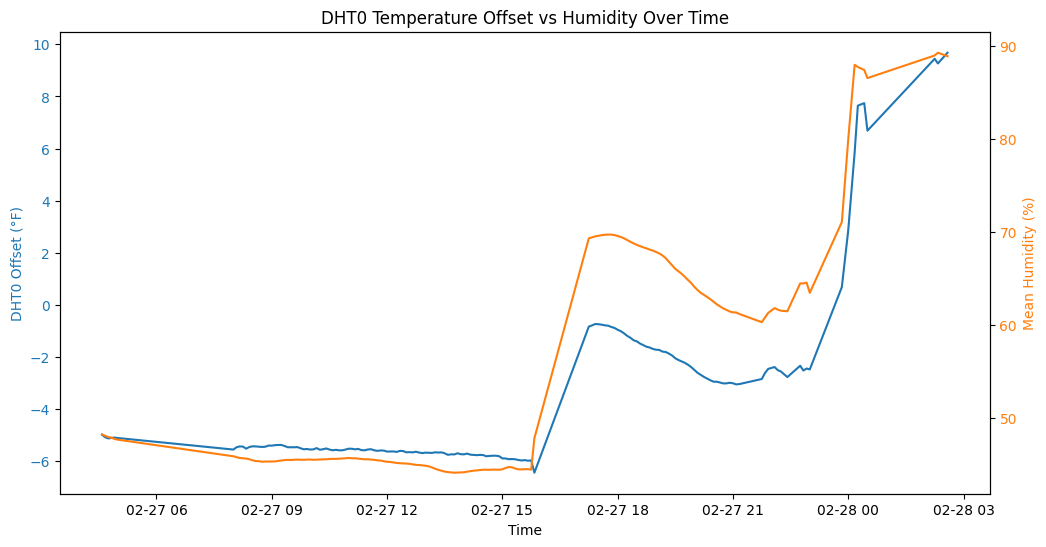

In [322]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis for temperature offset
ax1.set_xlabel('Time')
ax1.set_ylabel('DHT0 Offset (°F)', color='tab:blue')
ax1.plot(intervals["timestamp"], intervals["dht_0_humidity_offset"], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second axis for humidity
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Humidity (%)', color='tab:orange')
ax2.plot(intervals["timestamp"], intervals["mean_humidity"], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('DHT0 Temperature Offset vs Humidity Over Time')
plt.show()

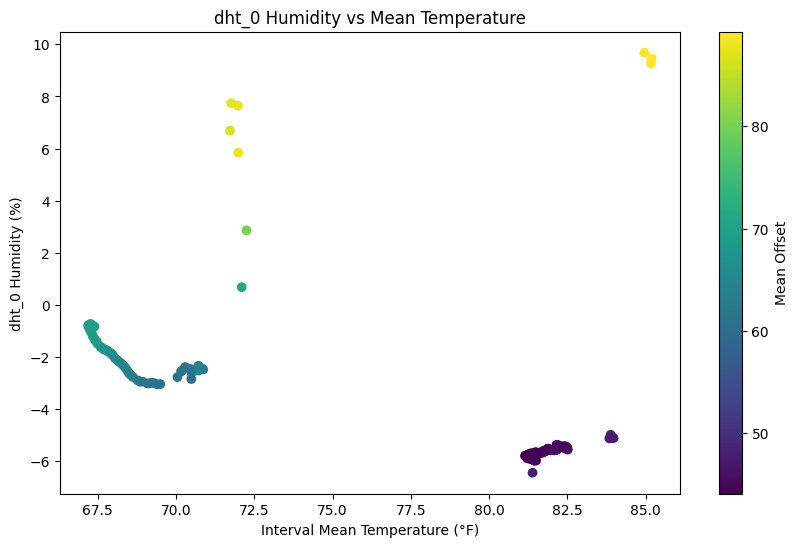

In [326]:
sensor = "dht_0"
# Convert to elapsed hours more carefully
stable_intervals = intervals.with_columns(
    ((pl.col("timestamp") - pl.col("timestamp").min())
     .dt.total_hours()
     .alias("elapsed_hours"))
)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    stable_intervals["interval_mean"],
    stable_intervals[f"{sensor}_humidity_offset"],
    c=stable_intervals[f"mean_humidity"],
    cmap="viridis"
)
plt.xlabel("Interval Mean Temperature (°F)")
plt.ylabel(f"{sensor} Humidity (%)")
plt.title(f"{sensor} Humidity vs Mean Temperature")
plt.colorbar(scatter, label="Mean Offset")
plt.show()

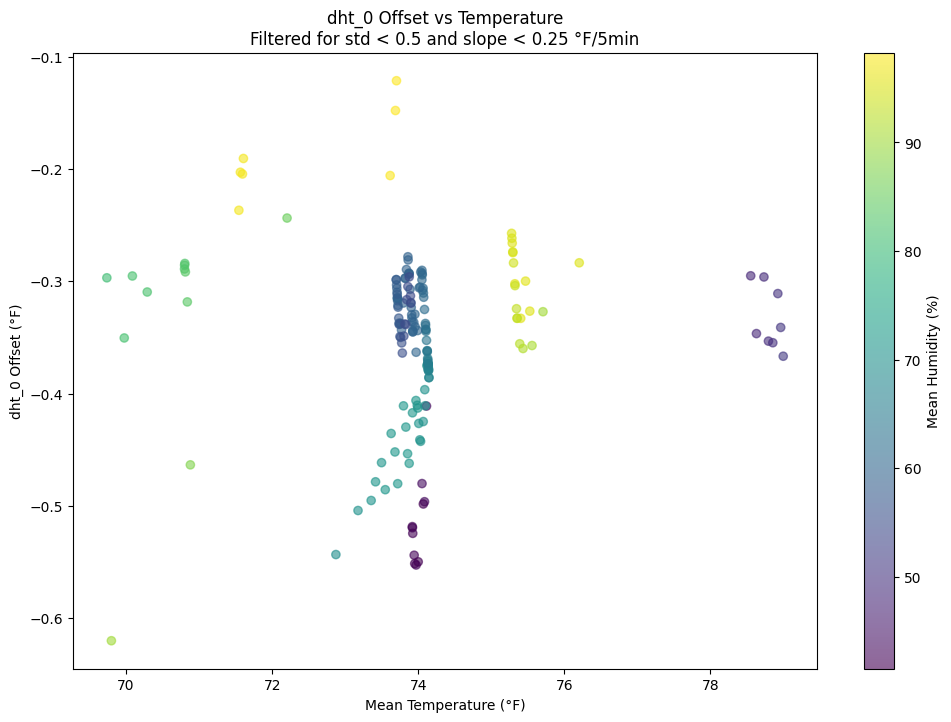

Number of stable intervals: 172


In [192]:
# Pick one sensor to visualize
sensor = "dht_0"  # or whichever sensor you want to look at

plt.figure(figsize=(12, 8))
scatter = plt.scatter(intervals["interval_mean"], 
                     intervals[f"{sensor}_offset"],
                     c=intervals["mean_humidity"],
                     cmap='viridis',
                     alpha=0.6)

plt.colorbar(scatter, label='Mean Humidity (%)')
plt.xlabel('Mean Temperature (°F)')
plt.ylabel(f'{sensor} Offset (°F)')
plt.title(f'{sensor} Offset vs Temperature\nFiltered for std < {y_threshold} and slope < 0.25 °F/5min')

plt.show()

# Print some basic stats about the remaining data points
print(f"Number of stable intervals: {len(intervals)}")

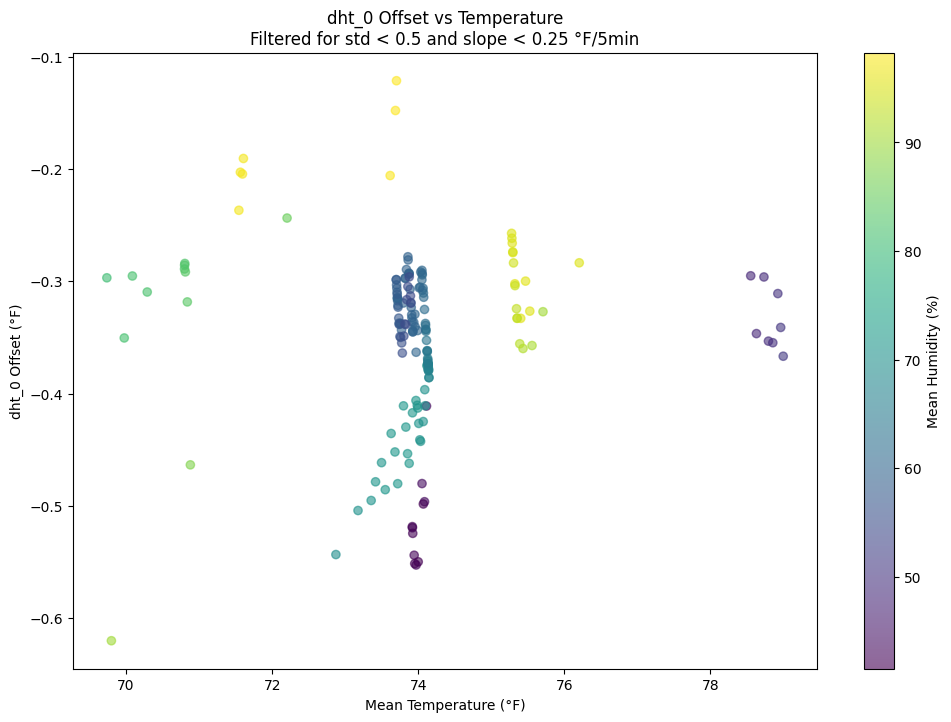

Number of stable intervals: 172


In [194]:
# Pick one sensor to visualize
sensor = "dht_0"  # or whichever sensor you want to look at

plt.figure(figsize=(12, 8))
scatter = plt.scatter(intervals["interval_mean"], 
                     intervals[f"{sensor}_offset"],
                     c=intervals["mean_humidity"],
                     cmap='viridis',
                     alpha=0.6)

plt.colorbar(scatter, label='Mean Humidity (%)')
plt.xlabel('Mean Temperature (°F)')
plt.ylabel(f'{sensor} Offset (°F)')
plt.title(f'{sensor} Offset vs Temperature\nFiltered for std < {y_threshold} and slope < 0.25 °F/5min')

plt.show()

# Print some basic stats about the remaining data points
print(f"Number of stable intervals: {len(intervals)}")

In [197]:
sensor = "dht_0"

# First let's see what our temperature range is
print("Temperature range:")
print(intervals.select([
    pl.col("interval_mean").min().alias("min_temp"),
    pl.col("interval_mean").max().alias("max_temp")
]))

# Then we can manually create the bins once we see the actual values
# This will help us determine the correct Polars syntax for creating the range

Temperature range:
shape: (1, 2)
┌──────────┬──────────┐
│ min_temp ┆ max_temp │
│ ---      ┆ ---      │
│ f64      ┆ f64      │
╞══════════╪══════════╡
│ 69.73697 ┆ 78.99576 │
└──────────┴──────────┘


/tmp/ipykernel_3232290/2163411503.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("points_in_bin")


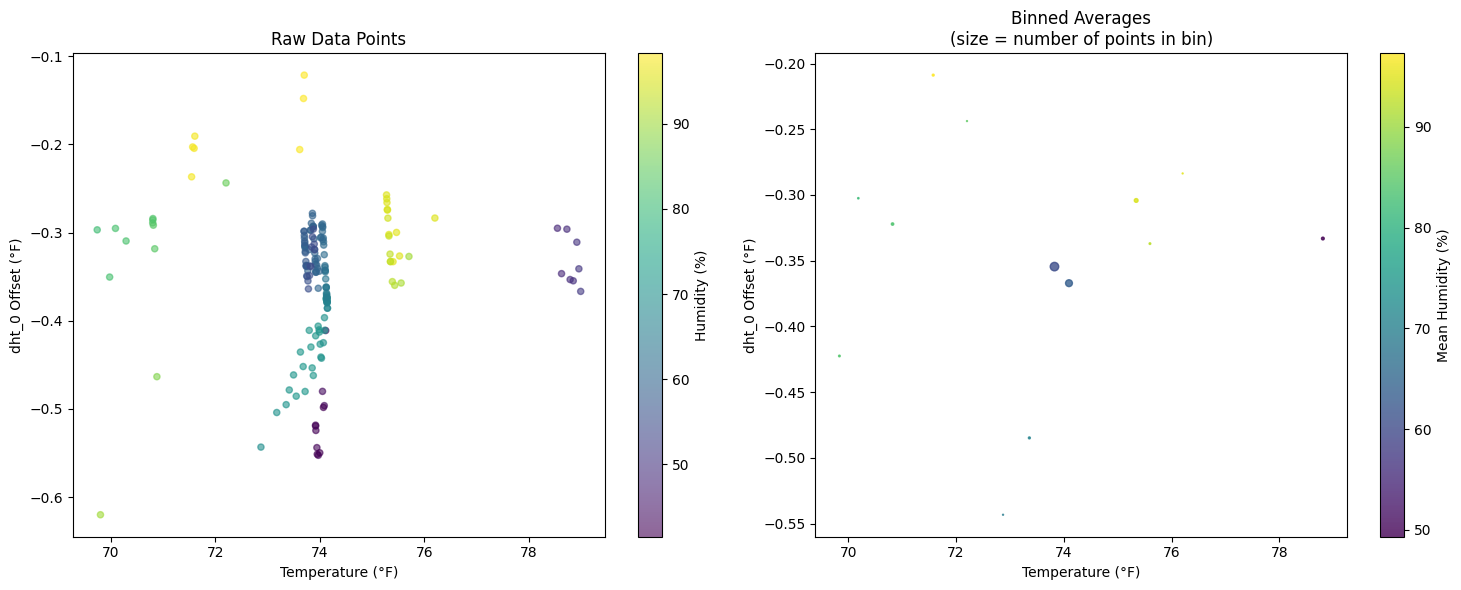


Bin Statistics:
shape: (13, 4)
┌───────────┬─────────────┬───────────────┬───────────────┐
│ bin_temp  ┆ mean_offset ┆ mean_humidity ┆ points_in_bin │
│ ---       ┆ ---         ┆ ---           ┆ ---           │
│ f64       ┆ f64         ┆ f64           ┆ u32           │
╞═══════════╪═════════════╪═══════════════╪═══════════════╡
│ 69.83699  ┆ -0.42249    ┆ 84.073896     ┆ 3             │
│ 70.187975 ┆ -0.302475   ┆ 81.846219     ┆ 2             │
│ 70.822612 ┆ -0.322112   ┆ 83.790635     ┆ 6             │
│ 71.577045 ┆ -0.208795   ┆ 97.318547     ┆ 4             │
│ 72.20377  ┆ -0.24377    ┆ 85.3345       ┆ 1             │
│ …         ┆ …           ┆ …             ┆ …             │
│ 74.095509 ┆ -0.367101   ┆ 63.547692     ┆ 49            │
│ 75.341867 ┆ -0.304167   ┆ 94.386167     ┆ 15            │
│ 75.597007 ┆ -0.337007   ┆ 92.313229     ┆ 3             │
│ 76.2036   ┆ -0.2836     ┆ 95.21575      ┆ 1             │
│ 78.804624 ┆ -0.333124   ┆ 49.315867     ┆ 8             │
└───────

In [206]:
sensor = "dht_0"

# Create bins manually from 69.5 to 79.5 in 0.5°F steps
bins = [69.5, 70.0, 70.5, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0, 
                 74.5, 75.0, 75.5, 76.0, 76.5, 77.0, 77.5, 78.0, 78.5, 79.0, 79.5]

# Group by temperature bins and calculate mean offset and humidity
binned_stats = intervals.with_columns([
    pl.col("interval_mean").cut(bins).alias("temp_bin")
]).group_by("temp_bin").agg([
    pl.col("interval_mean").mean().alias("bin_temp"),
    pl.col(f"{sensor}_offset").mean().alias("mean_offset"),
    pl.col("mean_humidity").mean().alias("mean_humidity"),
    pl.count().alias("points_in_bin")
])

# Plot the binned data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original scatter plot
scatter1 = ax1.scatter(intervals["interval_mean"], 
                      intervals[f"{sensor}_offset"],
                      c=intervals["mean_humidity"],
                      cmap='viridis',
                      alpha=0.6,
                      s=20)
ax1.set_xlabel('Temperature (°F)')
ax1.set_ylabel(f'{sensor} Offset (°F)')
ax1.set_title('Raw Data Points')
plt.colorbar(scatter1, ax=ax1, label='Humidity (%)')

# Binned data
scatter2 = ax2.scatter(binned_stats["bin_temp"], 
                      binned_stats["mean_offset"],
                      c=binned_stats["mean_humidity"],
                      s=binned_stats["points_in_bin"]/2,  # size represents number of points
                      cmap='viridis',
                      alpha=0.8)
ax2.set_xlabel('Temperature (°F)')
ax2.set_ylabel(f'{sensor} Offset (°F)')
ax2.set_title('Binned Averages\n(size = number of points in bin)')
plt.colorbar(scatter2, ax=ax2, label='Mean Humidity (%)')

plt.tight_layout()
plt.show()

# Print statistics about the bins
print("\nBin Statistics:")
print(binned_stats.sort("bin_temp").select(
    ["bin_temp", "mean_offset", "mean_humidity", "points_in_bin"]
))

In [213]:
intervals

timestamp,max_std,mean_std,interval_mean,mean_humidity,mean_sht_0_humidity,mean_bme280_0_humidity,mean_bme280_1_humidity,mean_dht_0_humidity,abs_slope_5min,ds18b20_0_offset,bme280_0_offset,sht_0_offset,bme280_1_offset,ds18b20_1_offset,dht_0_offset
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-02-25 12:05:00 UTC,0.479674,0.467068,70.83842,83.591313,83.91475,82.89725,82.77325,84.78,0.021895,0.29233,0.68833,-0.29617,0.84258,-0.16867,-0.31842
2025-02-25 12:10:00 UTC,0.498598,0.471533,70.80012,82.688812,83.10925,81.6125,81.9685,84.065,0.062316,0.26188,0.68988,-0.31862,0.85788,-0.19087,-0.28912
2025-02-25 12:15:00 UTC,0.499146,0.490078,70.81172,83.474813,83.7955,82.7945,82.61175,84.6975,0.009263,0.26403,0.71678,-0.31422,0.90278,-0.21347,-0.29172
2025-02-25 12:20:00 UTC,0.498913,0.484513,70.80418,82.751063,83.16425,81.616,81.9165,84.3075,0.002526,0.23857,0.70882,-0.32318,0.89082,-0.20593,-0.28418
2025-02-25 12:30:00 UTC,0.49146,0.483341,70.80128,82.751375,83.2205,81.83675,81.84575,84.1025,0.051368,0.22772,0.71122,-0.31103,0.89222,-0.20578,-0.28578
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-02-26 19:05:00 UTC,0.485515,0.476473,75.35288,92.47725,91.43975,91.144,91.46025,95.865,0.032842,0.17887,0.70137,-0.28263,0.88962,-0.15013,-0.33288
2025-02-26 19:10:00 UTC,0.489283,0.47803,75.38918,92.17525,91.06325,90.96575,91.107,95.565,0.019368,0.21682,0.69232,-0.26418,0.89832,-0.14243,-0.35568
2025-02-26 19:15:00 UTC,0.493592,0.479973,75.43391,91.734,90.54775,90.54275,90.608,95.2375,0.061263,0.18859,0.69434,-0.26891,0.90284,-0.13216,-0.35991


In [207]:
intervals

timestamp,max_std,mean_std,interval_mean,mean_humidity,abs_slope_5min,ds18b20_0_offset,bme280_0_offset,sht_0_offset,bme280_1_offset,ds18b20_1_offset,dht_0_offset
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-02-25 12:05:00 UTC,0.479674,0.467068,70.83842,83.591313,0.021895,0.29233,0.68833,-0.29617,0.84258,-0.16867,-0.31842
2025-02-25 12:10:00 UTC,0.498598,0.471533,70.80012,82.688812,0.062316,0.26188,0.68988,-0.31862,0.85788,-0.19087,-0.28912
2025-02-25 12:15:00 UTC,0.499146,0.490078,70.81172,83.474813,0.009263,0.26403,0.71678,-0.31422,0.90278,-0.21347,-0.29172
2025-02-25 12:20:00 UTC,0.498913,0.484513,70.80418,82.751063,0.002526,0.23857,0.70882,-0.32318,0.89082,-0.20593,-0.28418
2025-02-25 12:30:00 UTC,0.49146,0.483341,70.80128,82.751375,0.051368,0.22772,0.71122,-0.31103,0.89222,-0.20578,-0.28578
…,…,…,…,…,…,…,…,…,…,…,…
2025-02-26 19:05:00 UTC,0.485515,0.476473,75.35288,92.47725,0.032842,0.17887,0.70137,-0.28263,0.88962,-0.15013,-0.33288
2025-02-26 19:10:00 UTC,0.489283,0.47803,75.38918,92.17525,0.019368,0.21682,0.69232,-0.26418,0.89832,-0.14243,-0.35568
2025-02-26 19:15:00 UTC,0.493592,0.479973,75.43391,91.734,0.061263,0.18859,0.69434,-0.26891,0.90284,-0.13216,-0.35991


<Axes: xlabel='mean_humidity', ylabel='Count'>

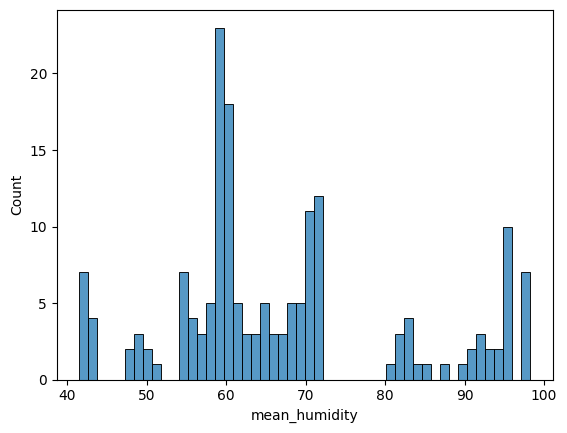